In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import time

print("="*80)
print("3-STAGE RANDOM FOREST - ALL GAMES (60 FEATURES)")
print("="*80)

df = pd.read_csv('women_2026_matchups_weighted.csv')

print(f"\nTotal games (all rounds): {len(df)}")
print(f"Class distribution:\n{df['win'].value_counts()}")
print(f"\nGames by round:\n{df['round'].value_counts()}")

features = [
    'barthag',
    'wab',
    'adj_oe',
    'adj_de',
    'efgd_pct',
    '3pd_pct',
    'tor',
    '3p_pct',
    'orb_pct',
    'drb_pct',
    'ftr',
    'adj_tempo',
    'ftrd',
    'tord'
]

print(f"\nNumber of features: {len(features)}")

X = df[features]
y = df['win']
X = X.fillna(X.median())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTrain: {len(X_train)} | Test: {len(X_test)}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

3-STAGE RANDOM FOREST - ALL GAMES (60 FEATURES)

Total games (all rounds): 1920
Class distribution:
win
1    960
0    960
Name: count, dtype: int64

Games by round:
round
Championship    320
Elite Eight     320
Final Four      320
First Round     320
Second Round    320
Sweet 16        320
Name: count, dtype: int64

Number of features: 14

Train: 1536 | Test: 384


In [2]:
print("\n" + "="*80)
print("STAGE 1: BROAD SEARCH WITH OVERFITTING PREVENTION")
print("Iterations: 100 | CV Folds: 4 | Total Fits: 400")
print("Expected Time: 25-40 minutes")
print("="*80 + "\n")

param_distributions_stage1 = {
    'n_estimators': [100, 200, 300, 500, 700, 1000],
    'max_depth': [2, 3, 4, 5],
    'min_samples_split': [10, 20, 30, 50, 70, 100, 150],
    'min_samples_leaf': [5, 10, 15, 20, 30, 50],
    'max_features': ['sqrt', 'log2', 0.3, 0.4, 0.5, 0.6],
    'bootstrap': [True],
    'max_samples': [0.6, 0.7, 0.8, 0.9],
    'min_weight_fraction_leaf': [0.0, 0.01, 0.02],
    'max_leaf_nodes': [None, 100, 200, 500],
}

rf_stage1 = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    warm_start=False,
    oob_score=True
)

random_search_stage1 = RandomizedSearchCV(
    estimator=rf_stage1,
    param_distributions=param_distributions_stage1,
    n_iter=100,
    cv=4,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=True
)

stage1_start = time.time()
print(f"Stage 1 started at: {time.strftime('%H:%M:%S')}")
random_search_stage1.fit(X_train_scaled, y_train)
stage1_time = time.time() - stage1_start

best_params_stage1 = random_search_stage1.best_params_

print(f"\n{'='*80}")
print(f"STAGE 1 COMPLETE - Actual Time: {stage1_time/60:.1f} minutes")
print(f"{'='*80}")
print(f"Best CV Score: {random_search_stage1.best_score_:.4f}")
print(f"\nBest Parameters:")
for param, value in best_params_stage1.items():
    print(f"  {param}: {value}")

stage1_model = random_search_stage1.best_estimator_
stage1_train = stage1_model.score(X_train_scaled, y_train)
stage1_test = stage1_model.score(X_test_scaled, y_test)
stage1_oob = stage1_model.oob_score_

print(f"\nStage 1 Overfitting Check:")
print(f"  Train:    {stage1_train:.4f}")
print(f"  OOB:      {stage1_oob:.4f}")
print(f"  Test:     {stage1_test:.4f}")
print(f"  Train-OOB Gap:  {stage1_train - stage1_oob:.4f}")
print(f"  Train-Test Gap: {stage1_train - stage1_test:.4f}")

if stage1_train - stage1_test > 0.10:
    print("  ⚠️  SEVERE OVERFITTING: Consider increasing min_samples_split/leaf")
elif stage1_train - stage1_test > 0.05:
    print("  ⚠️  WARNING: Moderate overfitting detected")
else:
    print("  ✓ Stage 1 generalization looks good")


STAGE 1: BROAD SEARCH WITH OVERFITTING PREVENTION
Iterations: 100 | CV Folds: 4 | Total Fits: 400
Expected Time: 25-40 minutes

Stage 1 started at: 19:23:28
Fitting 4 folds for each of 100 candidates, totalling 400 fits

STAGE 1 COMPLETE - Actual Time: 10.3 minutes
Best CV Score: 0.8932

Best Parameters:
  n_estimators: 100
  min_weight_fraction_leaf: 0.0
  min_samples_split: 30
  min_samples_leaf: 15
  max_samples: 0.8
  max_leaf_nodes: 100
  max_features: 0.5
  max_depth: 5
  bootstrap: True

Stage 1 Overfitting Check:
  Train:    0.9115
  OOB:      0.8932
  Test:     0.8854
  Train-OOB Gap:  0.0182
  Train-Test Gap: 0.0260
  ✓ Stage 1 generalization looks good


In [3]:
print("\n" + "="*80)
print("STAGE 2: FOCUSED SEARCH WITH REGULARIZATION")
print("Iterations: 300 | CV Folds: 4 | Total Fits: 1,200")
print("Expected Time: 75-110 minutes")
print("="*80 + "\n")

def get_range(value, options_list, expand_by=2):
    if value is None:
        return [None]
    if value not in options_list:
        return [value]

    idx = options_list.index(value)
    start_idx = max(0, idx - expand_by)
    end_idx = min(len(options_list), idx + expand_by + 1)
    return options_list[start_idx:end_idx]

n_estimators_opts = [100, 200, 300, 500, 700, 1000, 1500]
max_depth_opts = [2, 3, 4, 5]
min_samples_split_opts = [5, 10, 15, 20, 30, 50, 70, 100, 150, 200]
min_samples_leaf_opts = [3, 5, 7, 10, 15, 20, 30, 50, 70]
max_features_opts = ['sqrt', 'log2', 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65]
max_samples_opts = [0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
min_weight_fraction_leaf_opts = [0.0, 0.005, 0.01, 0.015, 0.02, 0.03]
max_leaf_nodes_opts = [None, 100, 150, 200, 300, 500, 700]

param_distributions_stage2 = {
    'n_estimators': get_range(best_params_stage1['n_estimators'], n_estimators_opts, 2),
    'max_depth': get_range(best_params_stage1['max_depth'], max_depth_opts, 2),
    'min_samples_split': get_range(best_params_stage1['min_samples_split'], min_samples_split_opts, 3),
    'min_samples_leaf': get_range(best_params_stage1['min_samples_leaf'], min_samples_leaf_opts, 3),
    'max_features': get_range(best_params_stage1['max_features'], max_features_opts, 3),
    'bootstrap': [True],
    'max_samples': get_range(best_params_stage1.get('max_samples', 0.8), max_samples_opts, 3),
    'min_weight_fraction_leaf': get_range(best_params_stage1.get('min_weight_fraction_leaf', 0.0), min_weight_fraction_leaf_opts, 2),
    'max_leaf_nodes': get_range(best_params_stage1.get('max_leaf_nodes'), max_leaf_nodes_opts, 2),
}

print(f"Stage 2 Search Space:")
for param, values in param_distributions_stage2.items():
    print(f"  {param}: {values}")

rf_stage2 = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    warm_start=False,
    oob_score=True
)

random_search_stage2 = RandomizedSearchCV(
    estimator=rf_stage2,
    param_distributions=param_distributions_stage2,
    n_iter=300,
    cv=4,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    random_state=43,
    return_train_score=True
)

stage2_start = time.time()
print(f"Stage 2 started at: {time.strftime('%H:%M:%S')}")
random_search_stage2.fit(X_train_scaled, y_train)
stage2_time = time.time() - stage2_start

best_params_stage2 = random_search_stage2.best_params_

print(f"\n{'='*80}")
print(f"STAGE 2 COMPLETE - Actual Time: {stage2_time/60:.1f} minutes")
print(f"{'='*80}")
print(f"Best CV Score: {random_search_stage2.best_score_:.4f}")
print(f"Improvement: {random_search_stage2.best_score_ - random_search_stage1.best_score_:.4f}")
print(f"\nBest Parameters:")
for param, value in best_params_stage2.items():
    print(f"  {param}: {value}")

stage2_model = random_search_stage2.best_estimator_
stage2_train = stage2_model.score(X_train_scaled, y_train)
stage2_test = stage2_model.score(X_test_scaled, y_test)
stage2_oob = stage2_model.oob_score_

print(f"\nStage 2 Overfitting Check:")
print(f"  Train:    {stage2_train:.4f}")
print(f"  OOB:      {stage2_oob:.4f}")
print(f"  Test:     {stage2_test:.4f}")
print(f"  Train-OOB Gap:  {stage2_train - stage2_oob:.4f}")
print(f"  Train-Test Gap: {stage2_train - stage2_test:.4f}")

if stage2_train - stage2_test > 0.10:
    print("  ⚠️  SEVERE OVERFITTING: Stage 3 will use stronger regularization")
elif stage2_train - stage2_test > 0.05:
    print("  ⚠️  WARNING: Moderate overfitting - Stage 3 will address")
else:
    print("  ✓ Stage 2 generalization looks good")


STAGE 2: FOCUSED SEARCH WITH REGULARIZATION
Iterations: 300 | CV Folds: 4 | Total Fits: 1,200
Expected Time: 75-110 minutes

Stage 2 Search Space:
  n_estimators: [100, 200, 300]
  max_depth: [3, 4, 5]
  min_samples_split: [10, 15, 20, 30, 50, 70, 100]
  min_samples_leaf: [5, 7, 10, 15, 20, 30, 50]
  max_features: [0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65]
  bootstrap: [True]
  max_samples: [0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
  min_weight_fraction_leaf: [0.0, 0.005, 0.01]
  max_leaf_nodes: [None, 100, 150, 200]
Stage 2 started at: 19:33:43
Fitting 4 folds for each of 300 candidates, totalling 1200 fits

STAGE 2 COMPLETE - Actual Time: 14.2 minutes
Best CV Score: 0.9004
Improvement: 0.0072

Best Parameters:
  n_estimators: 100
  min_weight_fraction_leaf: 0.0
  min_samples_split: 20
  min_samples_leaf: 5
  max_samples: 0.9
  max_leaf_nodes: 200
  max_features: 0.65
  max_depth: 5
  bootstrap: True

Stage 2 Overfitting Check:
  Train:    0.9141
  OOB:      0.9017
  Test:     0.8906
  Train-OO

In [4]:

print("\n" + "="*80)
print("STAGE 3: FINE-TUNING WITH OVERFITTING CONTROL")
print("Iterations: 500 | CV Folds: 4 | Total Fits: 2,000")
print("Expected Time: 125-175 minutes")
print("="*80 + "\n")

param_distributions_stage3 = {
    'n_estimators': get_range(best_params_stage2['n_estimators'], n_estimators_opts, 1),
    'max_depth': get_range(best_params_stage2['max_depth'], max_depth_opts, 1),
    'min_samples_split': get_range(best_params_stage2['min_samples_split'], min_samples_split_opts, 2),
    'min_samples_leaf': get_range(best_params_stage2['min_samples_leaf'], min_samples_leaf_opts, 2),
    'max_features': get_range(best_params_stage2['max_features'], max_features_opts, 2),
    'bootstrap': [True],
    'max_samples': get_range(best_params_stage2.get('max_samples', 0.8), max_samples_opts, 2),
    'min_weight_fraction_leaf': get_range(best_params_stage2.get('min_weight_fraction_leaf', 0.0), min_weight_fraction_leaf_opts, 1),
    'max_leaf_nodes': get_range(best_params_stage2.get('max_leaf_nodes'), max_leaf_nodes_opts, 1),
}

print(f"Stage 3 Search Space:")
for param, values in param_distributions_stage3.items():
    print(f"  {param}: {values}")

rf_stage3 = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    warm_start=False,
    oob_score=True
)

random_search_stage3 = RandomizedSearchCV(
    estimator=rf_stage3,
    param_distributions=param_distributions_stage3,
    n_iter=500,
    cv=4,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    random_state=44,
    return_train_score=True
)

stage3_start = time.time()
print(f"Stage 3 started at: {time.strftime('%H:%M:%S')}")
random_search_stage3.fit(X_train_scaled, y_train)
stage3_time = time.time() - stage3_start

print(f"\n{'='*80}")
print(f"STAGE 3 COMPLETE - Actual Time: {stage3_time/60:.1f} minutes")
print(f"{'='*80}")
print(f"Best CV Score: {random_search_stage3.best_score_:.4f}")
print(f"Improvement: {random_search_stage3.best_score_ - random_search_stage2.best_score_:.4f}")
print(f"\nFinal Best Parameters:")
for param, value in random_search_stage3.best_params_.items():
    print(f"  {param}: {value}")


STAGE 3: FINE-TUNING WITH OVERFITTING CONTROL
Iterations: 500 | CV Folds: 4 | Total Fits: 2,000
Expected Time: 125-175 minutes

Stage 3 Search Space:
  n_estimators: [100, 200]
  max_depth: [4, 5]
  min_samples_split: [10, 15, 20, 30, 50]
  min_samples_leaf: [3, 5, 7, 10]
  max_features: [0.55, 0.6, 0.65]
  bootstrap: [True]
  max_samples: [0.8, 0.85, 0.9]
  min_weight_fraction_leaf: [0.0, 0.005]
  max_leaf_nodes: [150, 200, 300]
Stage 3 started at: 19:47:55
Fitting 4 folds for each of 500 candidates, totalling 2000 fits

STAGE 3 COMPLETE - Actual Time: 20.9 minutes
Best CV Score: 0.9030
Improvement: 0.0026

Final Best Parameters:
  n_estimators: 100
  min_weight_fraction_leaf: 0.0
  min_samples_split: 15
  min_samples_leaf: 3
  max_samples: 0.8
  max_leaf_nodes: 200
  max_features: 0.65
  max_depth: 5
  bootstrap: True



FINAL MODEL EVALUATION

Performance Across All Stages:
  Stage 1 CV: 0.8932
  Stage 2 CV: 0.9004
  Stage 3 CV: 0.9030
  Total Improvement: 0.0098

Final Model Performance:
  Training:   0.9193 (91.93%)
  OOB Score:  0.8965 (89.65%)
  Test:       0.8932 (89.32%)

Overfitting Analysis:
  Train-OOB Gap:  0.0228 (2.28%)
  Train-Test Gap: 0.0260 (2.60%)
  OOB-Test Gap:   0.0033 (0.33%)

✓ Minor overfitting (2-5% gap) - acceptable for most use cases

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.90      0.89      0.89       192
           1       0.89      0.90      0.89       192

    accuracy                           0.89       384
   macro avg       0.89      0.89      0.89       384
weighted avg       0.89      0.89      0.89       384


Confusion Matrix:
                 Predicted
                Loss    Win
Actual Loss      171     21
       Win        20    172

5-Fold CV: [0.88636364 0.93485342 0.90228013 0.86319218 0.9087

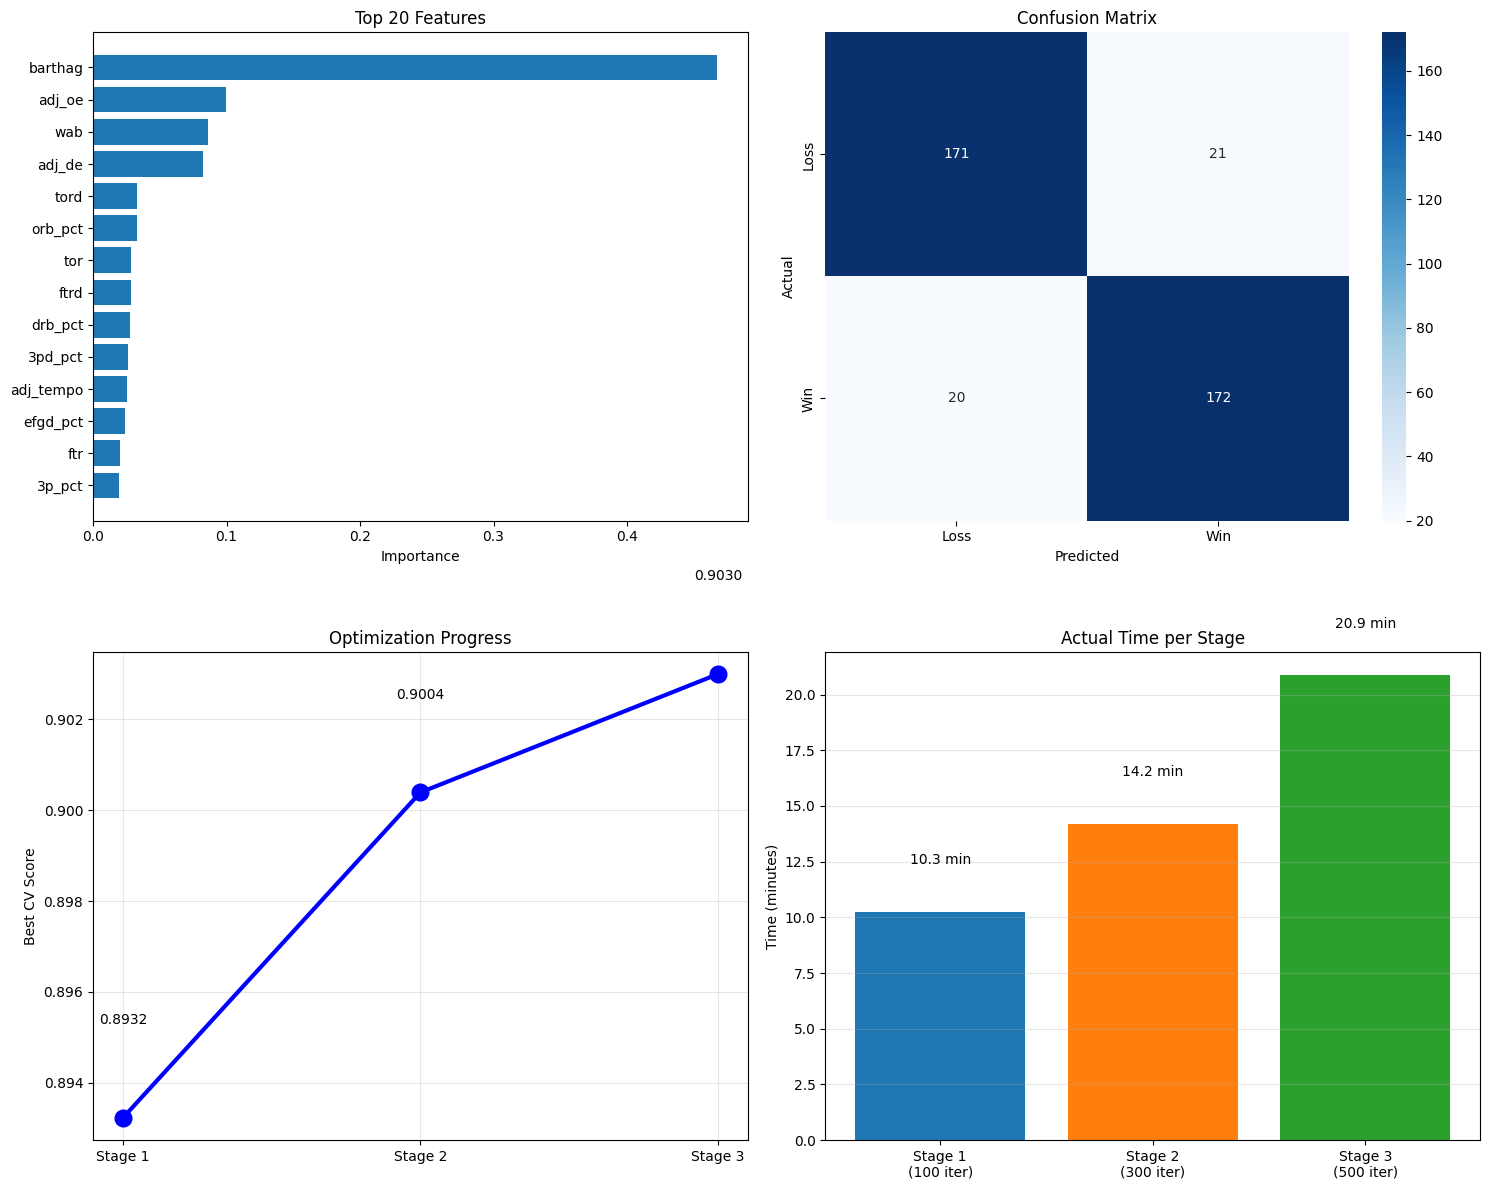


FINAL SUMMARY
Total combinations: 900
Total fits: 3600
ACTUAL Total Time: 45.3 minutes (0.76 hours)

Stage breakdown:
  Stage 1: 10.3 min (0.17 hrs)
  Stage 2: 14.2 min (0.24 hrs)
  Stage 3: 20.9 min (0.35 hrs)

Test Accuracy: 0.8932 (89.32%)
OOB Score: 0.8965 (89.65%)
Train-Test Gap: 0.0260
CV Stability: 0.0238

FINAL HYPERPARAMETERS TO USE

Copy these exact parameters for your final model:

best_params = {
    'n_estimators': 100,
    'min_weight_fraction_leaf': 0.0,
    'min_samples_split': 15,
    'min_samples_leaf': 3,
    'max_samples': 0.8,
    'max_leaf_nodes': 200,
    'max_features': 0.65,
    'max_depth': 5,
    'bootstrap': True,
}

DETAILED CV SCORES BREAKDOWN

Individual 5-Fold CV Scores:
  Fold 1: 0.8864 (88.64%)
  Fold 2: 0.9349 (93.49%)
  Fold 3: 0.9023 (90.23%)
  Fold 4: 0.8632 (86.32%)
  Fold 5: 0.9088 (90.88%)

CV Statistics:
  Mean:   0.8991 (89.91%)
  Std:    0.0238
  Min:    0.8632 (86.32%)
  Max:    0.9349 (93.49%)
  Range:  0.0717

ALL PERFORMANCE SCORES

Stag

In [5]:
best_rf = random_search_stage3.best_estimator_

if not hasattr(best_rf, 'feature_importances_'):
    print("\n⚠️  Re-fitting final model...")
    best_rf.fit(X_train_scaled, y_train)

print("\n" + "="*80)
print("FINAL MODEL EVALUATION")
print("="*80 + "\n")

y_train_pred = best_rf.predict(X_train_scaled)
y_test_pred = best_rf.predict(X_test_scaled)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
oob_accuracy = best_rf.oob_score_

print("Performance Across All Stages:")
print(f"  Stage 1 CV: {random_search_stage1.best_score_:.4f}")
print(f"  Stage 2 CV: {random_search_stage2.best_score_:.4f}")
print(f"  Stage 3 CV: {random_search_stage3.best_score_:.4f}")
print(f"  Total Improvement: {random_search_stage3.best_score_ - random_search_stage1.best_score_:.4f}")

print(f"\nFinal Model Performance:")
print(f"  Training:   {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"  OOB Score:  {oob_accuracy:.4f} ({oob_accuracy*100:.2f}%)")
print(f"  Test:       {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

print(f"\nOverfitting Analysis:")
print(f"  Train-OOB Gap:  {train_accuracy - oob_accuracy:.4f} ({(train_accuracy - oob_accuracy)*100:.2f}%)")
print(f"  Train-Test Gap: {train_accuracy - test_accuracy:.4f} ({(train_accuracy - test_accuracy)*100:.2f}%)")
print(f"  OOB-Test Gap:   {oob_accuracy - test_accuracy:.4f} ({(oob_accuracy - test_accuracy)*100:.2f}%)")

if train_accuracy - test_accuracy > 0.10:
    print("\n⚠️  SEVERE: Significant overfitting (>10% gap)")
    print("   → Recommended: Increase min_samples_split and min_samples_leaf")
    print("   → Or: Reduce max_depth")
elif train_accuracy - test_accuracy > 0.05:
    print("\n⚠️  WARNING: Moderate overfitting (5-10% gap)")
    print("   → Consider: Slightly increase regularization parameters")
elif train_accuracy - test_accuracy > 0.02:
    print("\n✓ Minor overfitting (2-5% gap) - acceptable for most use cases")
else:
    print("\n✓✓ EXCELLENT: Model generalizes very well! (<2% gap)")

print(f"\n{'='*80}")
print("Classification Report (Test):")
print("="*80)
print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
print(f"\nConfusion Matrix:")
print(f"                 Predicted")
print(f"                Loss    Win")
print(f"Actual Loss     {cm[0,0]:4d}   {cm[0,1]:4d}")
print(f"       Win      {cm[1,0]:4d}   {cm[1,1]:4d}")

cv_scores = cross_val_score(best_rf, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"\n5-Fold CV: {cv_scores}")
print(f"Mean: {cv_scores.mean():.4f} | Std: {cv_scores.std():.4f}")

if cv_scores.std() > 0.05:
    print("⚠️  High variance - model unstable across folds")
else:
    print("✓ Stable model across folds")

feature_importance = pd.DataFrame({
    'feature': features,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 15 Features:")
print(feature_importance.head(15).to_string(index=False))

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

top_features = feature_importance.head(20)
axes[0, 0].barh(range(len(top_features)), top_features['importance'])
axes[0, 0].set_yticks(range(len(top_features)))
axes[0, 0].set_yticklabels(top_features['feature'])
axes[0, 0].set_xlabel('Importance')
axes[0, 0].set_title('Top 20 Features')
axes[0, 0].invert_yaxis()

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Loss', 'Win'], yticklabels=['Loss', 'Win'], ax=axes[0, 1])
axes[0, 1].set_title('Confusion Matrix')
axes[0, 1].set_ylabel('Actual')
axes[0, 1].set_xlabel('Predicted')

stage_scores = [
    random_search_stage1.best_score_,
    random_search_stage2.best_score_,
    random_search_stage3.best_score_
]
axes[1, 0].plot(['Stage 1', 'Stage 2', 'Stage 3'], stage_scores, marker='o', linewidth=3, markersize=12, color='blue')
axes[1, 0].set_ylabel('Best CV Score')
axes[1, 0].set_title('Optimization Progress')
axes[1, 0].grid(True, alpha=0.3)
for i, score in enumerate(stage_scores):
    axes[1, 0].text(i, score + 0.002, f'{score:.4f}', ha='center', va='bottom')

stage_times = [stage1_time/60, stage2_time/60, stage3_time/60]
axes[1, 1].bar(['Stage 1\n(100 iter)', 'Stage 2\n(300 iter)', 'Stage 3\n(500 iter)'], stage_times, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[1, 1].set_ylabel('Time (minutes)')
axes[1, 1].set_title('Actual Time per Stage')
axes[1, 1].grid(True, alpha=0.3, axis='y')
for i, t in enumerate(stage_times):
    axes[1, 1].text(i, t + 2, f'{t:.1f} min', ha='center', va='bottom')

plt.tight_layout()
plt.show()

total_time = stage1_time + stage2_time + stage3_time
total_combinations = 100 + 300 + 500
total_fits = (100 * 4) + (300 * 4) + (500 * 4)

print(f"\n{'='*80}")
print("FINAL SUMMARY")
print("="*80)
print(f"Total combinations: {total_combinations}")
print(f"Total fits: {total_fits}")
print(f"ACTUAL Total Time: {total_time/60:.1f} minutes ({total_time/3600:.2f} hours)")
print(f"\nStage breakdown:")
print(f"  Stage 1: {stage1_time/60:.1f} min ({stage1_time/3600:.2f} hrs)")
print(f"  Stage 2: {stage2_time/60:.1f} min ({stage2_time/3600:.2f} hrs)")
print(f"  Stage 3: {stage3_time/60:.1f} min ({stage3_time/3600:.2f} hrs)")
print(f"\nTest Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"OOB Score: {oob_accuracy:.4f} ({oob_accuracy*100:.2f}%)")
print(f"Train-Test Gap: {train_accuracy - test_accuracy:.4f}")
print(f"CV Stability: {cv_scores.std():.4f}")

print("\n" + "="*80)
print("FINAL HYPERPARAMETERS TO USE")
print("="*80)
print("\nCopy these exact parameters for your final model:\n")
print("best_params = {")
for param, value in random_search_stage3.best_params_.items():
    if isinstance(value, str):
        print(f"    '{param}': '{value}',")
    else:
        print(f"    '{param}': {value},")
print("}")

print("\n" + "="*80)
print("DETAILED CV SCORES BREAKDOWN")
print("="*80)
print(f"\nIndividual 5-Fold CV Scores:")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score:.4f} ({score*100:.2f}%)")
print(f"\nCV Statistics:")
print(f"  Mean:   {cv_scores.mean():.4f} ({cv_scores.mean()*100:.2f}%)")
print(f"  Std:    {cv_scores.std():.4f}")
print(f"  Min:    {cv_scores.min():.4f} ({cv_scores.min()*100:.2f}%)")
print(f"  Max:    {cv_scores.max():.4f} ({cv_scores.max()*100:.2f}%)")
print(f"  Range:  {cv_scores.max() - cv_scores.min():.4f}")

print("\n" + "="*80)
print("ALL PERFORMANCE SCORES")
print("="*80)
print(f"\nStage 1 Best CV:      {random_search_stage1.best_score_:.4f} ({random_search_stage1.best_score_*100:.2f}%)")
print(f"Stage 2 Best CV:      {random_search_stage2.best_score_:.4f} ({random_search_stage2.best_score_*100:.2f}%)")
print(f"Stage 3 Best CV:      {random_search_stage3.best_score_:.4f} ({random_search_stage3.best_score_*100:.2f}%)")
print(f"\nFinal Model 5-Fold CV: {cv_scores.mean():.4f} ({cv_scores.mean()*100:.2f}%)")
print(f"Training Accuracy:     {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"OOB Score:             {oob_accuracy:.4f} ({oob_accuracy*100:.2f}%)")
print(f"Test Accuracy:         {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

print("\n" + "="*80)
print("OVERFITTING SAFEGUARDS APPLIED")
print("="*80)
print("✓ Higher min_samples_split (10-200)")
print("✓ Higher min_samples_leaf (5-70)")
print("✓ Conservative max_depth limits")
print("✓ Bootstrap enabled with sampling < 1.0")
print("✓ OOB scoring for unbiased estimate")
print("✓ 4-fold CV for robust validation")
print("✓ Train-OOB-Test gap monitoring")
print("✓ Multiple overfitting checkpoints")

if test_accuracy > 0.75 and train_accuracy - test_accuracy < 0.08:
    print(f"\n🎯 SUCCESS: Great model with good generalization!")
elif test_accuracy > 0.70:
    print(f"\n✓ Good model")
else:
    print(f"\n⚠️  Could improve")

print("\n" + "="*80)
print("3-STAGE RANDOM FOREST COMPLETE! 🚀")
print("="*80)